# Emulate COSMOS observations with MassiveNuS

In this notebook, we create a toy dataset using MassiveNuS and the mask from the COSMOS survey.

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [3]:
from astropy.io import fits
import tensorflow as tf
import tensorflow_datasets as tfds
from jax_lensing.spectral import measure_power_spectrum
from jax_lensing.datasets.massivenu import MassiveNu
from jax_lensing.inversion import ks93, ks93inv
import jax.numpy as jnp

In [4]:
# These show the borders of the cosmos field
COSMOS_VERTICES = [(149.508, 2.880),
                   (149.767, 2.836),
                   (149.780, 2.887),
                   (150.040, 2.842),
                   (150.051, 2.893),
                   (150.363, 2.840),
                   (150.376, 2.890),
                   (150.746, 2.826),
                   (150.737, 2.774),
                   (150.790, 2.765),
                   (150.734, 2.449),
                   (150.787, 2.441),
                   (150.730, 2.125),
                   (150.785, 2.118),
                   (150.758, 2.013),
                   (150.768, 2.010),
                   (150.747, 1.910),
                   (150.799, 1.897),
                   (150.740, 1.580),
                   (150.481, 1.625),
                   (150.466, 1.572),
                   (150.211, 1.619),
                   (150.196, 1.567),
                   (149.887, 1.621),
                   (149.872, 1.571),
                   (149.617, 1.615),
                   (149.602, 1.566),
                   (149.493, 1.584),
                   (149.504, 1.637),
                   (149.450, 1.646),
                   (149.488, 1.855),
                   (149.433, 1.862),
                   (149.491, 2.178),
                   (149.436, 2.186),
                   (149.484, 2.445),
                   (149.431, 2.455),
                   (149.508, 2.880)]

from lenspack.geometry.projections import gnom
def get_extend_radec():
    ra0, dec0 = (150.11, 2.24) # from cosmos.astro.caltech.edu (could also just use the medians of positions)
    proj = gnom.projector(ra0, dec0)
    pix_size=0.4 #arcmin
    dx = np.deg2rad(320*pix_size/60./2) # number of degrees across
    dy = dx
    extent_xy = [-dx, dx, -dy, dy]
    ra_min, dec_min = proj.xy2radec(-dx, -dy)
    ra_max, dec_max = proj.xy2radec(dx, dy)
    extent_radec = [ra_min, ra_max, dec_min, dec_max]
    return extent_radec

In [5]:
# Let's prepare some test data
def load_dataset():
  def pre_process(im):
    """ Pre-processing function preparing data for denoising task
    """
    # Cutout a portion of the map
    x = tf.expand_dims(im['map'],-1)
    return x
  ds = tfds.load('massive_nu', split='train[:-10%]', shuffle_files=False)
  ds = ds.map(pre_process)
  return iter(tfds.as_numpy(ds))

In [6]:
# Instantiate dataset and sample map
dset = load_dataset()
ref_map = next(dset)
ref_map = next(dset)
ref_map = next(dset)
# Load mask from COSMOS
mask = fits.getdata('../data/cosmos_mask_0.4arcmin.fits').astype('float32')

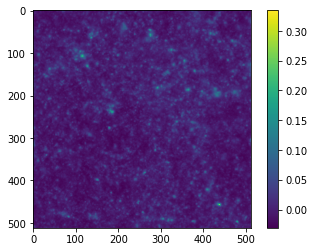

In [7]:
# This is our input map
imshow(ref_map); colorbar();

In [8]:
# We turn it into shear
e1,e2 = ks93inv(ref_map[...,0], jnp.zeros_like(ref_map[...,0]))
# And we extract a patch that put the big cluster right at the edge
k = ref_map[256-160:256+160,256-160:256+160,0]
e1 = e1[256-160:256+160,256-160:256+160]
e2 = e2[256-160:256+160,256-160:256+160]

(-0.5, 319.5, 319.5, -0.5)

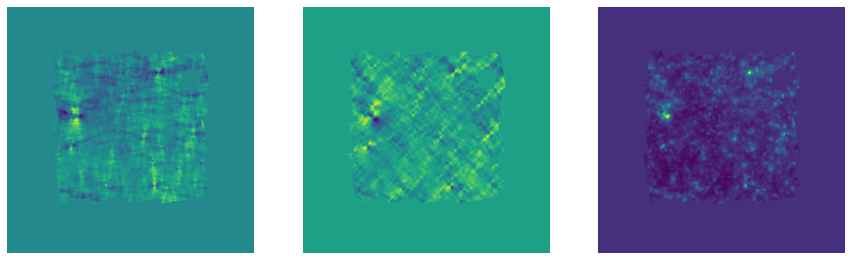

In [9]:
figure(figsize=[15,5])
subplot(131)
imshow(e1*mask)
axis('off')
subplot(132)
imshow(e2*mask)
axis('off')
subplot(133)
imshow(k*mask)
axis('off')

In [10]:
# We are going to simulate observations for 30 galaxies per sq. arcmin.
ngal_cosmos = 8 # This how many galaxies we have in real cosmos data
sigma_noise = 0.15*sqrt(8)/sqrt(30) # We have a noise of 0.15 in real data
print("effective noise per pixel and components:", sigma_noise )

effective noise per pixel and components: 0.07745966692414834


In [12]:
# And, last but not least, we can also include reduced shear
g1 = e1 / (1 - k)
g2 = e2 / (1 - k)

In [13]:
# We can save for testing this map with added noise
fits.writeto('../data/Mnu_cosmos_kappa.fits',k)
fits.writeto('../data/Mnu_cosmos_e.fits',
              np.stack([mask*(g1 + sigma_noise*randn(320,320)),
                        mask*(g2 + sigma_noise*randn(320,320))],axis=-1))

OSError: File '../data/Mnu_cosmos_kappa.fits' already exists.

In [15]:
# We can also produce a noiser set of data that matches the observations
fits.writeto('../data/Mnu_cosmos_e_bright.fits',
              np.stack([mask*(g1 + 0.15*randn(320,320)),
                        mask*(g2 + 0.15*randn(320,320))],axis=-1))

At this point, you can run the sampling code with:
```
python scripts/sample_maps.py --shear=data/Mnu_cosmos_e.fits --mask=data/cosmos_mask_0.4arcmin.fits --model_weights=/data/Scores/lensing/training_kl1_gaussian_01noise/model-final.pckl --output_file=test_samples.fits --batch_size=32 --gaussian_only=True --output_steps=2 --sigma_gamma=0.077
```

In [17]:
# And load the results
maps = []
for i in range(16):
    s1 = fits.getdata('/data/NeurIPS_results/reconstructions_sims/gpu1_samples_ml_%d.fits'%(i+1)).astype('float32')
    s2 = fits.getdata('/data/NeurIPS_results/reconstructions_sims/gpu2_samples_ml_%d.fits'%(i+1)).astype('float32')
    maps.append(s1)
    maps.append(s2)

In [18]:
s = np.concatenate(maps, axis=1)

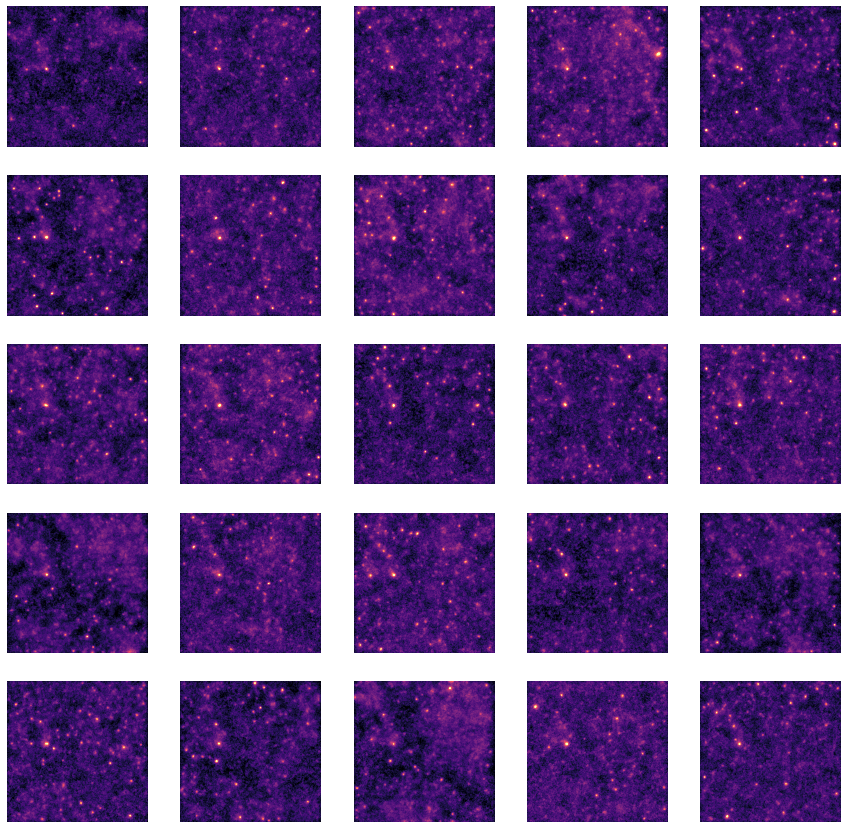

In [26]:
# Let's plot a few samples from the posterior
figure(figsize=[15,15])
for i in range(5):
    for j in range(5):
        subplot(5, 5, i*5+j+1)
        imshow(s[-1,i*5+j].reshape((320,320)),cmap='magma',
               vmin=-0.05, vmax=0.2)
        axis('off')

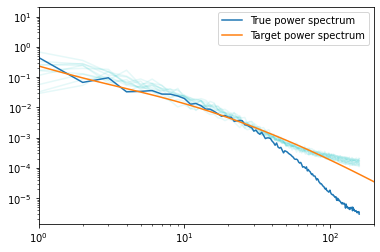

In [21]:
# We can also look at their Power Spectra compared to the true PS
# of the map
k =fits.getdata('../data/Mnu_cosmos_kappa.fits').astype('float32')
ps_data = np.load('../data/massivenu/mnu0.0_Maps10_PS_theory.npy').astype('float32')
ell = jnp.array(ps_data[0,:])
ps_halofit = jnp.array(ps_data[4,:] / 0.000116355**2) # normalisation by pixel size
# convert to pixel units of our simple power spectrum calculator
kell = ell / (360/3.5/0.5) / 320

for i in range(10):
    loglog(measure_power_spectrum(s[-1,i].reshape((320,320))),c='c',alpha=0.1)

loglog(measure_power_spectrum(k), label='True power spectrum')
loglog(kell*320,ps_halofit, label='Target power spectrum')
xlim(1,200)
legend()



In [ ]:
# files = []
# for i in range(32):
#     plt.cla()
#     im = s[-1, i].reshape((320, 320))
#     imshow(im,cmap='magma',vmin=-0.05, vmax=0.1, 
#            origin='lower', extent=get_extend_radec())
#     xlim(gca().get_xlim()[::-1])
#     ra, dec = np.array(COSMOS_VERTICES).T
#     plot(ra, dec,  c='w', lw=1)
#     xlabel('ra')
#     ylabel('dec')
    
#     fname = '_tmp%03d.png' % i
#     plt.savefig(fname,dpi=300)
#     files.append(fname)

To make a movie out of these images:
```
ffmpeg -r 15 -f image2  -i _tmp%3d.png  -vcodec libx264 -crf 15  movie_mnu_gaussian.mp4
```

In [22]:
# We can also produce a standard Kaiser-Squires inversion
meas_shear = fits.getdata('../data/Mnu_cosmos_e_bright.fits').astype('float32')
mask = fits.getdata('../data/cosmos_mask_0.4arcmin.fits').astype('float32')
ksmap,_ = ks93(meas_shear[...,0], meas_shear[...,1])

In [23]:
# And let's apply some smoothing
from scipy.ndimage import gaussian_filter
gauss_ksmap = gaussian_filter(ksmap, 3) # 3 pixels corresponds to 1.2 arcmin

Text(0.5, 1.0, 'Filtered KS map')

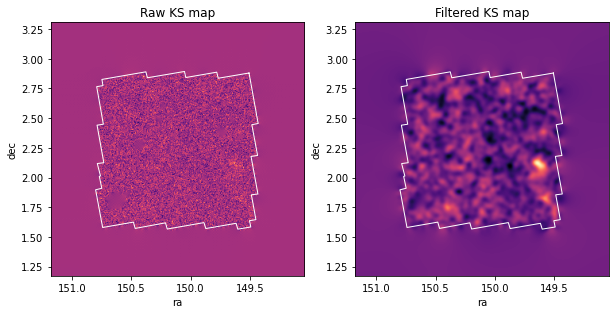

In [24]:
figure(figsize=[10,5])
subplot(121)
imshow(ksmap,cmap='magma', 
       origin='lower', extent=get_extend_radec())
xlim(gca().get_xlim()[::-1])
ra, dec = np.array(COSMOS_VERTICES).T
plot(ra, dec,  c='w', lw=1)
xlabel('ra')
ylabel('dec')
title('Raw KS map')

subplot(122)
imshow(gauss_ksmap,cmap='magma', 
       origin='lower', extent=get_extend_radec())
xlim(gca().get_xlim()[::-1])
ra, dec = np.array(COSMOS_VERTICES).T
plot(ra, dec,  c='w', lw=1)
xlabel('ra')
ylabel('dec')
title('Filtered KS map')

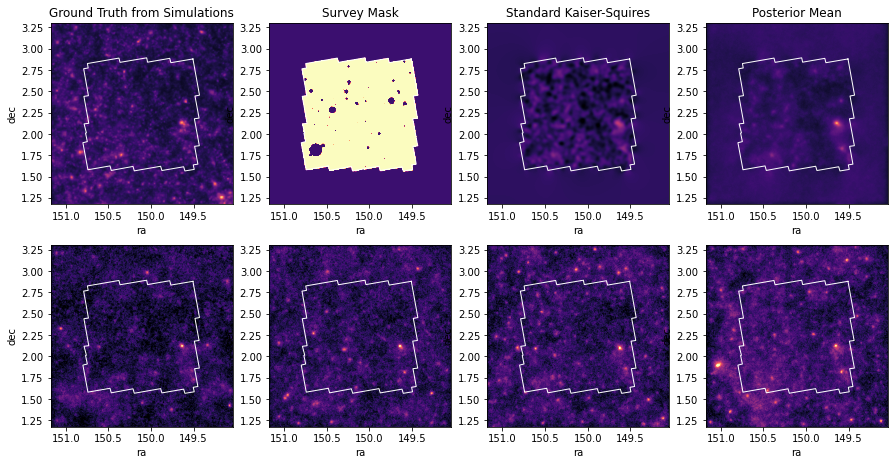

In [31]:
figure(figsize=[15,7.5])

subplot(241)
title('Ground Truth from Simulations')
imshow(k,cmap='magma',vmin=-0.05, vmax=0.25, 
       origin='lower', extent=get_extend_radec())
xlabel('ra')
ylabel('dec')
xlim(gca().get_xlim()[::-1])
ra, dec = np.array(COSMOS_VERTICES).T
plot(ra, dec,  c='w', lw=1)

subplot(242)
title('Survey Mask')
imshow(mask,cmap='magma',vmin=-0.05, vmax=0.2, 
       origin='lower', extent=get_extend_radec())
xlabel('ra')
ylabel('dec')
xlim(gca().get_xlim()[::-1])
ra, dec = np.array(COSMOS_VERTICES).T
plot(ra, dec,  c='w', lw=1)

subplot(243)
title('Standard Kaiser-Squires')
imshow(gauss_ksmap,cmap='magma',vmin=-0.05, vmax=0.25,
       origin='lower', extent=get_extend_radec())
xlim(gca().get_xlim()[::-1])
ra, dec = np.array(COSMOS_VERTICES).T
plot(ra, dec,  c='w', lw=1)
xlabel('ra')
ylabel('dec')

subplot(244)
title('Posterior Mean')
imshow(mean(s[-1],axis=0).reshape((320,320)),
       cmap='magma',vmin=-0.05, vmax=0.25, 
       origin='lower', extent=get_extend_radec())
xlim(gca().get_xlim()[::-1])
ra, dec = np.array(COSMOS_VERTICES).T
plot(ra, dec,  c='w', lw=1)
xlabel('ra')
ylabel('dec')

subplot(245)
im = s[-1, 0].reshape((320, 320))
imshow(im,cmap='magma',vmin=-0.05, vmax=0.25, 
       origin='lower', extent=get_extend_radec())
xlim(gca().get_xlim()[::-1])
ra, dec = np.array(COSMOS_VERTICES).T
plot(ra, dec,  c='w', lw=1)
xlabel('ra')
ylabel('dec')

subplot(246)
im = s[-1, 1].reshape((320, 320))
imshow(im,cmap='magma',vmin=-0.05, vmax=0.25, 
       origin='lower', extent=get_extend_radec())
xlim(gca().get_xlim()[::-1])
ra, dec = np.array(COSMOS_VERTICES).T
plot(ra, dec,  c='w', lw=1)
xlabel('ra')
ylabel('dec')

subplot(247)
im = s[-1, 2].reshape((320, 320))
imshow(im,cmap='magma',vmin=-0.05, vmax=0.25, 
       origin='lower', extent=get_extend_radec())
xlim(gca().get_xlim()[::-1])
ra, dec = np.array(COSMOS_VERTICES).T
plot(ra, dec,  c='w', lw=1)
xlabel('ra')
ylabel('dec')

subplot(248)
im = s[-1, 3].reshape((320, 320))
imshow(im,cmap='magma',vmin=-0.05, vmax=0.25, 
       origin='lower', extent=get_extend_radec())
xlim(gca().get_xlim()[::-1])
ra, dec = np.array(COSMOS_VERTICES).T
plot(ra, dec,  c='w', lw=1)
xlabel('ra')
ylabel('dec')
savefig('mnu_reconstruction_ml.pdf', bbox_inches='tight', pad_inches=0)